In [1]:
%matplotlib widget

import configparser
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

from tathu.io import spatialite, pgis
from tathu import visualizer
from tathu.utils import extractPeriods, file2timestamp, array2raster, getGeoT, geo2grid

## Versão Py-ART

In [ ]:
from read_sipam_cappis import read_sipam_cappi

def get_files(filepath):
    """Return filelist according to a txt file"""
    filelist = open(filepath, "r")
    files = [line.strip() for line in filelist]
    return files

def read_radar(path, level, family_ext = False):
    """Reading radar data (specifically SIPAM CAPPIs)"""

    cappi = read_sipam_cappi(path)

    # Get original extent
    extent = [
        cappi.get_point_longitude_latitude()[0].min(),
        cappi.get_point_longitude_latitude()[1].max(),
        cappi.get_point_longitude_latitude()[0].max(),
        cappi.get_point_longitude_latitude()[1].min(),
    ]
    # print("original extent: ", extent)
    # Get grid original resolution
    gt = getGeoT(extent, 241, 241)
    # print(gt)
    if family_ext is not False:
        # print("family extent: ", family_ext)
        # Creating new extent
        upper_left_geo = (family_ext[0], family_ext[1])
        lower_right_geo = (family_ext[2], family_ext[3])
        upper_left_grid = geo2grid(upper_left_geo[0], upper_left_geo[1], gt)
        lower_right_grid = geo2grid(lower_right_geo[0], lower_right_geo[1], gt)
        min_lin = upper_left_grid[0]
        max_lin = lower_right_grid[0]
        min_col = upper_left_grid[1]
        max_col = lower_right_grid[1]
        slice_lon = slice(min_col, max_col)
        slice_lat = slice(min_lin, max_lin)
        # print("slice_lon: ", slice_lon)
        # print("slice_lat: ", slice_lat)
        extent = [
            cappi.get_point_longitude_latitude()[0][slice_lat, slice_lon].min(),
            cappi.get_point_longitude_latitude()[1][slice_lat, slice_lon].min(),
            cappi.get_point_longitude_latitude()[0][slice_lat, slice_lon].max(),
            cappi.get_point_longitude_latitude()[1][slice_lat, slice_lon].max(),
        ]
        # print("cappi new extent: ", extent)

        # Slice the data
        array = np.flipud(cappi.fields["DBZc"]["data"][level][slice_lat, slice_lon])
    else:
        array = np.flipud(cappi.fields["DBZc"]["data"][level])
    return array, extent

## Versão array

In [9]:
from read_sipam_cappis_cptec import read_simple_cappi

def get_files(filepath):
    """Return filelist according to a txt file"""
    filelist = open(filepath, "r")
    files = [line.strip() for line in filelist]
    return files

def read_radar(path, level, family_ext = False):
    """Reading radar data (specifically CPTEC SIPAM CAPPIs)"""

    cappi, coords = read_simple_cappi(path, "/".join(path.split("/")[:-3]))

    # Get original extent
    extent = [
            np.nanmin(coords[0]),
            np.nanmin(coords[1]),
            np.nanmax(coords[0]),
            np.nanmax(coords[1]),
    ]
    # print("original extent: ", extent)
    # Get grid original resolution
    gt = getGeoT(extent, 250, 250)  # CHECK RESOLUTION
    # print(gt)
    if family_ext is not False:
        # print("family extent: ", family_ext)
        # Creating new extent
        upper_left_geo = (family_ext[0], family_ext[3])
        lower_right_geo = (family_ext[2], family_ext[1])
        upper_left_grid = geo2grid(upper_left_geo[0], upper_left_geo[1], gt)
        lower_right_grid = geo2grid(lower_right_geo[0], lower_right_geo[1], gt)
        # print("upper_left: ", upper_left_grid)
        # print("lower_right: ", lower_right_grid)
        min_lin = upper_left_grid[0]
        max_lin = lower_right_grid[0]
        min_col = upper_left_grid[1]
        max_col = lower_right_grid[1]
        slice_lon = slice(min_col, max_col)
        slice_lat = slice(min_lin, max_lin)
        # print("slice_lon: ", slice_lon)
        # print("slice_lat: ", slice_lat)
        extent = [
            np.nanmin(coords[0][slice_lat, slice_lon]),
            np.nanmin(coords[1][slice_lat, slice_lon]),
            np.nanmax(coords[0][slice_lat, slice_lon]),
            np.nanmax(coords[1][slice_lat, slice_lon]),
        ]
        # print("cappi new extent: ", extent)

        # Slice the data
        array = np.flipud(cappi[level])[slice_lat, slice_lon]
    else:
        array = np.flipud(cappi[level])
    array[array == -99.] = np.nan
    return array, extent

# Loading sqlite/filtered csv databases

In [ ]:
# Setup informations to load systems from database
dbname = 'out/test_dry_season.sqlite'
table = 'systems'
csvname = "out/test_dry_season_filter.csv"

In [5]:
# Load family
# db = spatialite.Loader(dbname, table)
db = pgis.Loader("localhost", "goamazon_geo", "postgres", "postgres", "systems")
# Get systems
names = db.loadNames()

# Load csv
# csv = pd.read_csv(csvname)
# Get names
# names_filter = np.unique(csv[["name"]]).tolist()

In [4]:
len(names)

91613

# Loading radar data

In [3]:
# Read config file and extract infos
params = configparser.ConfigParser(interpolation=None)
params.read("/home/camilacl/git/tathu/sipam-tracking/config_sipam.ini")

# Get input data parameters
date_regex = params.get("input", "date_regex")
date_format = params.get("input", "date_format")
level = int(params.get("input", "level_index"))
# Get tracking parameters
timeout = float(params.get("tracking_parameters", "timeout"))


# Animação por família (`AnimationMap`)

/home/camilacl/miniconda3/envs/env-tathu/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


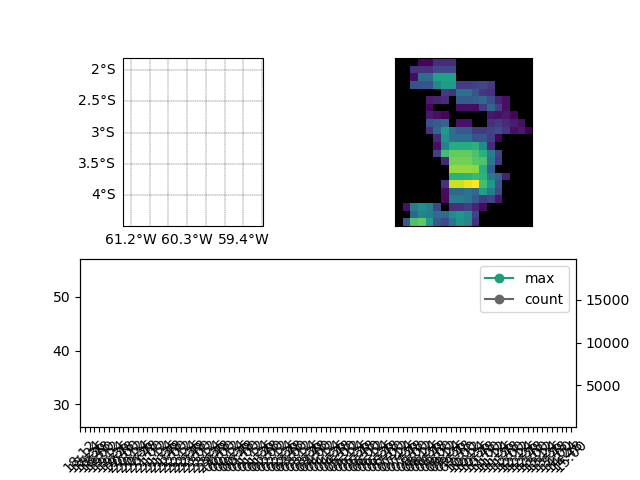

In [18]:
# Load first
family = db.load("d7dfe86a-4736-41a3-9232-c91ff00a7db0", ['max', 'mean', 'std', 'count'])

# Animation
aniview = visualizer.AnimationMap(family, ['max', 'count'])
aniview.show()

aniview.save("out/bigfam_d7dfe86a-4736-41a3-9232-c91ff00a7db0.mp4")

In [7]:
len(family.getEvents())

4

In [ ]:
family.getRasters()

# Histórico por família (`SystemHistoryView`)

In [ ]:
%matplotlib inline

for name in names_filter:
    # Load a family
    family = db.load(name, ['max', 'mean', 'std', 'count'])

    # Get timestamps of radar families
    filepath = "/home/camilacl/git/amazon-storms-aerosols/data/radar/sipam_manaus/cptec_cappi/"
    radar_files = [
        (
            filepath
            + str(i.year)
            + "/"
            + datetime.strftime(i, "%m")
            + "/cappi_"
            + datetime.strftime(i, date_format)
            + ".dat"
        )
        for i in family.getTimestamps()
    ]
    radar_data = [read_radar(i, level, family.getExtent())[0] for i in radar_files]
    radar_extent = read_radar(radar_files[0], level, family.getExtent())[1]

    hisview = visualizer.SystemHistoryView(family, radar_data, radar_extent)
    curr_fig = plt.gcf()
    hisview.show()
    curr_fig.savefig("out/fams/test_dry_" + name + ".png", dpi=300)
    plt.clf()
    plt.gca()


In [ ]:
family = db.load('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e', ['max', 'mean', 'std', 'count'])
hisview = visualizer.SystemHistoryView(family, family.getRasters())
hisview.show()

# Mapa com todos os sistemas (`MapView`)

In [ ]:
# Read config file and extract infos
params = configparser.ConfigParser(interpolation=None)
params.read("/home/camila/git/tathu/sipam-tracking/config_sipam.ini")

# Get input data parameters
data_in = params.get("input", "data_in")
date_regex = params.get("input", "date_regex")
date_format = params.get("input", "date_format")
level = int(params.get("input", "level_index"))
# Get tracking parameters
timeout = float(params.get("tracking_parameters", "timeout"))

# Get files
files = get_files(data_in)

# Misc

In [ ]:
filepath = "/home/camilacl/git/amazon-storms-aerosols/data/radar/sipam_manaus/cptec_cappi/"
[(filepath + str(i.year) + "/" + datetime.strftime(i, "%m") + "/cappi_" + datetime.strftime(i, date_format) + ".dat") for i in family.getTimestamps()]


In [ ]:
x = read_radar("/home/camila/git/amazon-storms-aerosols/data/radar/sipam_manaus/arm_cappi/2014-05/20140509/sbmn_cappi_20140509_114801.nc", level)[0]

import matplotlib.pyplot as plt

plt.imshow(x)

In [ ]:
extent